## 00: Loading your Google Hangout chat data
Throughout this tutorial, we will use a dataset containing all of my Google Hangout chat messages. I've removed the messages content and I've annonymized my friends names - but the rest of the dataset it unaltered.

If you'd like to use your Hangout chat data whilst working through this tutorial, you can download your Google Hangout data from [Google Takeout](https://www.google.com/settings/takeout/custom/chat). The Hangout data is downloadable in json format. After downloading, you can replace the `hangouts.json` file in the data folder.

The json file is heavily nested and contains a lot of redundant information. Some of the key fields are summarized below:

| Field           | Description                                                    | Example                                      |
|-----------------|----------------------------------------------------------------|----------------------------------------------|
| `conversation_id` | Conversation id representing the chat thread                   | Ugw5Xrm3ZO5mzAfKB7V4AaABAQ                   |
| `participants`    | List of participants in the chat thread                        | [Mark, Peter, John]                          |
| `event_id`        | Id representing an event such as chat message or video hangout | 7-H0Z7-FkyB7-H0au2avdw                       |
| `timestamp`       | Timestamp                                                      | 2014-08-15 01:54:12                          |
| `message`         | Content of the message sent                                    | Went to the local wedding photographer today |
| `sender`          | Sender of the message                                          | Mark Regan                                   |

In [30]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

The below code loads the json data and parses each message into a single row in a pandas DataFrame.

In [31]:
# Import json data
with open('data/hangouts.json') as json_file:
    json_data = json.load(json_file)

# Generate map from gaia_id to real name
def user_name_mapping(data):
    user_map = {'gaia_id': ''}
    for state in data['conversation_state']:
        participants = state['conversation_state']['conversation']['participant_data']
        for participant in participants:
            if 'fallback_name' in participant:
                user_map[participant['id']['gaia_id']] = participant['fallback_name']

    return user_map

user_dict = user_name_mapping(json_data)

# Parse data into flat list
def fetch_messages(data):
    messages = []
    for state in data['conversation_state']:
        conversation_state = state['conversation_state']
        conversation = conversation_state['conversation']
        conversation_id = conversation_state['conversation']['id']['id']
        participants = conversation['participant_data']

        all_participants = []
        for participant in participants:
            if 'fallback_name' in participant:
                user = participant['fallback_name']
            else:
                # Scope to call G+ API to get name
                user = participant['id']['gaia_id']
            all_participants.append(user)
            num_participants = len(all_participants)
        
        for event in conversation_state['event']:
            try:
                sender = user_dict[event['sender_id']['gaia_id']]
            except:
                sender = event['sender_id']['gaia_id']
            
            timestamp = datetime.fromtimestamp(long(long(event['timestamp'])/10**6.))
            event_id = event['event_id']

            if 'chat_message' in event:
                content = event['chat_message']['message_content']
                if 'segment' in content:
                    segments = content['segment']

                    for segment in segments:
                        if 'text' in segment:
                            message = segment['text'].strip()
                            message_length = len(message)
                            if len(message) != 0:
                                messages.append((conversation_id,
                                                 event_id, 
                                                 timestamp, 
                                                 sender, 
                                                 message,
                                                 message_length,
                                                 all_participants,
                                                 ', '.join(all_participants),
                                                 num_participants))

    messages.sort(key=lambda x: x[0])
    return messages

# Parse data into data frame
cols = ['conversation_id', 'event_id', 'timestamp', 'sender', 'message', 'message_length', 'participants', 'participants_str', 'num_participants']
messages = pd.DataFrame(fetch_messages(json_data), columns=cols).sort(['conversation_id', 'timestamp'])

In [32]:
# Engineer features
messages['prev_timestamp'] = messages.groupby(['conversation_id'])['timestamp'].shift(1)
messages['prev_sender'] = messages.groupby(['conversation_id'])['sender'].shift(1)

# Exclude messages are are replies to oneself (not first reply)
messages = messages[messages['sender'] != messages['prev_sender']]

# Time delay
messages['time_delay_seconds'] = (messages['timestamp'] - messages['prev_timestamp']).astype('timedelta64[s]')
messages = messages[messages['time_delay_seconds'].notnull()]
messages['time_delay_mins'] = np.ceil(messages['time_delay_seconds'].astype(int)/60.0)

# Time attributes
messages['day_of_week'] = messages['timestamp'].apply(lambda x: x.dayofweek)
messages['year_month'] = messages['timestamp'].apply(lambda x: x.strftime("%Y-%m"))
messages['is_weekend'] = messages['day_of_week'].isin([5,6]).apply(lambda x: 1 if x == True else 0)

# Limit to messages sent by me and exclude all messages between me and Alison
messages = messages[(messages['sender'] == 'Mark Regan') & (messages['participants_str'] != 'Alison Darcy, Mark Regan')]

# Remove messages not responded within 60 seconds
# This introduces an issue by right censoring the data (might return to address)
messages = messages[messages['time_delay_seconds'] < 60]

messages.head(1)

,conversation_id,event_id,timestamp,sender,message,message_length,participants,participants_str,num_participants,prev_timestamp,prev_sender,time_delay_seconds,time_delay_mins,day_of_week,year_month,is_weekend
10,Ugw5Xrm3ZO5mzAfKB7V4AaABAQ,7-H0Z7-FkyB7-HDBYj4KKh,2014-08-15 11:44:12,Mark Regan,Thanks guys!!!,14,"[Keir Alexander, Louise Alexander Regan, Mark ...","Keir Alexander, Louise Alexander Regan, Mark R...",3,2014-08-15 11:44:00,Keir Alexander,12,1,4,2014-08,0


We now have a data model that we can work with more easily. The above table shows a single row in the pandas DataFrame. I'm interested in how long it takes me to respond to messages. Lets create some plots that describe my typical response times.

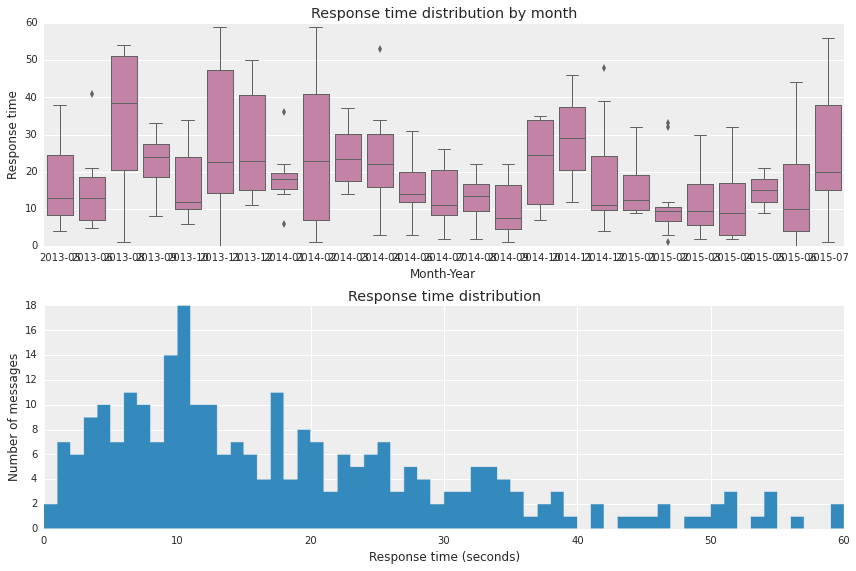

In [33]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(211)

order = np.sort(messages['year_month'].unique())
sns.boxplot(x=messages['year_month'], y=messages['time_delay_seconds'], order=order, orient="v", color=colors[5], linewidth=1, ax=ax)
_ = ax.set_title('Response time distribution by month')
_ = ax.set_xlabel('Month-Year')
_ = ax.set_ylabel('Response time')

ax = fig.add_subplot(212)
plt.hist(messages['time_delay_seconds'].values, range=[0, 60], bins=60, histtype='stepfilled', color=colors[0])
_ = ax.set_title('Response time distribution')
_ = ax.set_xlabel('Response time (seconds)')
_ = ax.set_ylabel('Number of messages')

plt.tight_layout()

Ok, so the above plots give a monthly and an overall perspective on the length of time (seconds) that it takes me to respond to messages. At this point I have a lot of questins that I want to ask of the data. Such as:
1. Is my response time affected by who I am talking to?
2. Are there environmental factors that affect my response time (day of week, location etc)
3. When is the best and worst day to get in touch with me?

Before we try and answer some of these questions, lets take some baby steps by estimating some parameters of a model that describe the above data. That'll make it easier for us to understand the data and enquire further.

Move onto the next section where we'll estimate parameters that describe the above distribution.

### Export data for usage throughout tutorial

In [34]:
# excluded some colums from csv output
messages.drop(['participants', 'message'], axis=1, inplace=True)

# Save csv to data folder
messages.to_csv('data/hangout_chat_data.csv')

In [35]:
# Apply pretty styles
from IPython.core.display import HTML

def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()